In [1]:
import backtrader as bt
import alpaca_backtrader_api as api
import alpaca_trade_api as tradeapi
import sys
sys.path.insert(0, '../')
import pandas as pd
import talib as ta
import numpy as np
from config import key_id, secret_key
from datetime import datetime 
from scipy import signal
import scipy
from pandas import DataFrame

In [2]:
#use modin for faster processing
#import modin.pandas as pd

In [3]:
data=pd.read_csv('data/JACK.csv')

In [4]:
type(data.index[0])

int

In [5]:
data2=data.set_index('timestamp').sort_index(ascending=False)

# Cleaning data


In [6]:
#converting timestamp row to timestamp type
data2.index=pd.to_datetime(data2.index, utc=True)

In [7]:
# Create a DatetimeIndex and assign it to the dataframe.
data2.index = pd.DatetimeIndex(data2.index)

In [8]:
#Count ticks on unique days
day_tick_cnt = data2.index.normalize() \
                     .value_counts() \
                     .to_frame().reset_index()

#Keep days that have ticks greater than 300
day_list=day_tick_cnt[~(day_tick_cnt['timestamp'] >= 240)]

In [9]:
len(day_tick_cnt)- len(day_list)

2690

In [10]:
#create date
data2['date']=data2.index.date

In [11]:
data2.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2020-04-09 16:24:00+00:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09
2020-04-09 16:23:00+00:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09


In [12]:
#if date is in data, keep the data
cond= data2['date'].isin(day_list['index'])
data2.drop(data2[cond].index, inplace = True)

In [13]:
#data should now be cleaned of days where data is spotty
data2.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2020-04-09 16:24:00+00:00,46.910,47.175,46.8900,47.1750,7793,2020-04-09
2020-04-09 16:23:00+00:00,46.865,46.960,46.8650,46.9600,2070,2020-04-09
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09


In [14]:
#create time frame of opening to one hour before closing/ after hours
#data=pd.DataFrame.between_time(data,"14:30","20:00")

# Create Features
## Adding indicators

In [15]:
import talib.abstract as tab

In [16]:
#make sure to import these packages
from pandas import DataFrame
import talib.abstract as tab
#abstract automatically extracts the columns and periods from the data itself, no input required



#feel free to add or subtract more indicators for any other strategy you want to use
def populateindicators(dataframe) -> DataFrame:
        #make sure to remove these later
        #exponential moving averages
        dataframe['sema_high'] = tab.EMA(dataframe, timeperiod=12, price='high')
        dataframe['fema_high'] = tab.EMA(dataframe, timeperiod=5, price='high')
        dataframe['ema_close'] = tab.EMA(dataframe, timeperiod=5, price='close')
        dataframe['ema_low'] = tab.EMA(dataframe, timeperiod=5, price='low')
        dataframe['dema'] = ta.DEMA(dataframe['close'], timeperiod=30)
        
        #mathematics
        
        macd=tab.MACD(dataframe, fastperiod=12, slowperiod=26, signalperiod=9)
        dataframe['macd'] = macd['macd']
        dataframe['macdsignal']=macd['macdsignal']
        dataframe['macdhist']=macd['macdhist']
        
        
        #stochastics
        stoch_fast = tab.STOCHF(dataframe, 10.0, 3.0, 0.0, 3.0, 0.0)
        stoch= tab.STOCH(dataframe, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
        stoch_rsi=tab.STOCHRSI(dataframe, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
        
        
        dataframe['slowd'] = stoch['slowd']
        dataframe['slowk'] = stoch['slowk']
        
        dataframe['fastdf'] = stoch_fast['fastd']
        dataframe['fastkf'] = stoch_fast['fastk']
        
        dataframe['fastdrsi'] = stoch_rsi['fastd']
        dataframe['fastkrsi'] = stoch_rsi['fastk']
        
        #momentum indicators
        #dataframe['willr'] = tab.WILLR(dataframe['high'].values, dataframe['low'].values, dataframe['close'].values)
        dataframe['ultosc'] = tab.ULTOSC(dataframe)
        
        
        dataframe['mfi'] = ta.MFI(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['volume'], dtype='float'), timeperiod=14)
        #dataframe['smfi'] = ta.MFI(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['volume'], dtype='float'), timeperiod=20)
        #dataframe['fmfi'] = ta.MFI(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['volume'], dtype='float'), timeperiod=8)
        
        dataframe['adx'] = tab.ADX(dataframe)
        #dataframe['fadx'] = tab.ADX(dataframe, timeperiod=8)
        #dataframe['sadx'] = tab.ADX(dataframe, timeperiod=20)
        
        dataframe['adxr'] = tab.ADXR(dataframe)
        
        #dataframe['adxr'] = tab.ADXR(dataframe)
        
        dataframe['cci'] = tab.CCI(dataframe)
        dataframe['rsi2'] = tab.RSI(dataframe, timeperiod=14)
        dataframe['rocr'] =tab.ROCR(dataframe)
        
        #statistics 
        #dataframe['sbeta']=tab.BETA(dataframe, timeperiod=9)
        dataframe['beta']=tab.BETA(dataframe, timeperiod=5)
        #dataframe['fbeta']=tab.BETA(dataframe, timeperiod=3)
        
        #dataframe['scorrel']=tab.CORREL(dataframe, timeperiod=30)
        dataframe['correl']=tab.CORREL(dataframe, timeperiod=17)
        #dataframe['fcorrel']=tab.CORREL(dataframe, timeperiod=10)
        
        #dataframe['svar']=tab.VAR(dataframe, timeperiod=8)
        dataframe['var']=tab.VAR(dataframe, timeperiod=5)
        #dataframe['fvar']=tab.VAR(dataframe, timeperiod=3)
        
        
        #create time indicators
        #dataframe['months']=dataframe.index.get_level_values(level='timestamp').month
        #dataframe['dayofweek']=dataframe.index.get_level_values(level='timestamp').dayofweek
        #dataframe['hourofday']=dataframe.index.get_level_values(level='timestamp').hour
        
        #pattern recognition indicators
        #dataframe['1']=tab.CD13OUTSIDE(dataframe)
        #dataframe['2']=tab.CDL3INSIDE(dataframe)
        #dataframe['3']=tab.CDLBELTHOLD(dataframe)
        #dataframe['4']=tab.CDLBREAKAWAY(dataframe)
        #dataframe['5']=tab.CDLCLOSINGMARUBOZU(dataframe)
        #dataframe['6']=tab.CDLDOJI(dataframe)
        dataframe['7']=tab.CDLDOJISTAR(dataframe)
        dataframe['8']=tab.CDLDRAGONFLYDOJI(dataframe)
        dataframe['9']=tab.CDLENGULFING(dataframe)
        dataframe['10']=tab.CDLGAPSIDESIDEWHITE(dataframe)
        dataframe['11']=tab.CDLGRAVESTONEDOJI(dataframe)
        dataframe['12']=tab.CDLHAMMER(dataframe)
        dataframe['13']=tab.CDLHANGINGMAN(dataframe)
        dataframe['14']=tab.CDLHARAMI(dataframe)
        dataframe['15']=tab.CDLHARAMICROSS(dataframe)
        dataframe['16']=tab.CDLHIGHWAVE(dataframe)
        dataframe['17']=tab.CDLHIKKAKE(dataframe)
        dataframe['18']=tab.CDLINVERTEDHAMMER(dataframe)
        dataframe['19']=tab.CDLLADDERBOTTOM(dataframe)
        dataframe['20']=tab.CDLLONGLEGGEDDOJI(dataframe)
        dataframe['21']=tab.CDLLONGLINE(dataframe)
        dataframe['22']=tab.CDLMARUBOZU(dataframe)
        dataframe['23']=tab.CDLMATCHINGLOW(dataframe)
        dataframe['24']=tab.CDLRICKSHAWMAN(dataframe)
        dataframe['25']=tab.CDLSEPARATINGLINES(dataframe)
        dataframe['26']=tab.CDLSHOOTINGSTAR(dataframe)
        dataframe['27']=tab.CDLSHORTLINE(dataframe)
        dataframe['28']=tab.CDLSPINNINGTOP(dataframe)
        dataframe['29']=tab.CDLTAKURI(dataframe)
        dataframe['30']=tab.CDLTRISTAR(dataframe)
        
        
        # required for graphing
        bollinger =ta.BBANDS(dataframe.close,timeperiod=10)
        dataframe['bb_lowerband'] = bollinger[2]
        dataframe['bb_upperband'] = bollinger[0]
        dataframe['bb_middleband'] = bollinger[1]
        
        #create volume based indicators
        ta.ADOSC(dataframe['high'], dataframe['low'], dataframe['close'], np.asarray(dataframe['volume'], dtype='float'))

        #Create volatility indicator
        dataframe['natr'] = tab.NATR(dataframe)
        
        #create row of labels/classification
        #if dataframe
            #dataframe['maxindex'] = tab.MAXINDEX(dataframe, timeperiod=30)
        
        
        
        
        return dataframe

In [17]:
#tab.MINUS_DI(data3)[0:50]

In [18]:
# Compute RSI
def relative_strength_index(df, n):
        """Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: pandas.DataFrame
        :param n: 
        :return: pandas.DataFrame
        """
        i = 0
        UpI = [0]
        DoI = [0]
        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)
        return RSI

def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [19]:


def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band



In [20]:
data3=data2.sort_index(ascending=True)

In [21]:
data3.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15


In [22]:
# Compute RSI
#rsi_df = get_rsi(data3, window=14)
#data3['rsi'] = pd.Series(data=rsi_df.values, index=data3.index)





In [23]:
data3.head()

,open,high,low,close,volume,date
timestamp,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15


In [24]:
# compute bands
#window = 50
#data3['avg'], data3['upper'], data3['lower'] = bbands(data3['close'], window, no_of_stdev=1.5)
#data3.sample(10)

In [25]:
data3=populateindicators(data3)
# Drop the NaN values from our data set
data3

,open,high,low,close,volume,date,sema_high,fema_high,ema_close,ema_low,...,25,26,27,28,29,30,bb_lowerband,bb_upperband,bb_middleband,natr
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 14:30:00+00:00,20.1000,20.1000,20.1000,20.1000,2504,2008-12-15,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2008-12-15 14:33:00+00:00,20.9500,20.9500,20.9500,20.9500,100,2008-12-15,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2008-12-15 14:35:00+00:00,20.9899,20.9899,20.9899,20.9899,500,2008-12-15,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2008-12-15 14:37:00+00:00,20.4800,20.4800,20.4800,20.4800,100,2008-12-15,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
2008-12-15 14:38:00+00:00,20.2450,20.2450,20.2450,20.2450,875,2008-12-15,NaN,20.552980,20.552980,20.552980,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 16:20:00+00:00,46.9300,46.9300,46.8100,46.8100,1410,2020-04-09,46.840367,46.858997,46.787209,46.742941,...,0,0,0,0,0,0,46.650887,46.933053,46.79197,0.367661
2020-04-09 16:21:00+00:00,46.9200,46.9200,46.8232,46.8232,763,2020-04-09,46.852618,46.879331,46.799206,46.769694,...,0,0,0,0,0,0,46.704254,46.914326,46.80929,0.358084
2020-04-09 16:22:00+00:00,46.8900,46.9000,46.7500,46.8700,3005,2020-04-09,46.859908,46.886221,46.822804,46.763129,...,0,0,0,0,0,0,46.702534,46.920046,46.81129,0.355034


In [26]:
data4=data3.dropna()

In [27]:
data4

,open,high,low,close,volume,date,sema_high,fema_high,ema_close,ema_low,...,25,26,27,28,29,30,bb_lowerband,bb_upperband,bb_middleband,natr
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 15:39:00+00:00,19.810,19.820,19.8000,19.8000,750,2008-12-15,19.920079,19.850298,19.830240,19.822830,...,0,0,0,0,0,0,19.703490,20.072510,19.88800,0.228589
2008-12-15 15:40:00+00:00,19.820,19.820,19.8000,19.8100,2500,2008-12-15,19.904682,19.840198,19.823494,19.815220,...,0,0,0,0,0,0,19.701815,20.031185,19.86650,0.219365
2008-12-15 15:41:00+00:00,19.800,19.820,19.8000,19.8050,1600,2008-12-15,19.891654,19.833466,19.817329,19.810147,...,0,0,0,0,0,0,19.753116,19.924884,19.83900,0.210961
2008-12-15 15:42:00+00:00,19.805,19.810,19.8000,19.8000,2600,2008-12-15,19.879092,19.825644,19.811553,19.806764,...,0,0,0,0,0,0,19.762786,19.889214,19.82600,0.199549
2008-12-15 15:43:00+00:00,19.810,19.810,19.8000,19.8100,1000,2008-12-15,19.868463,19.820429,19.811035,19.804510,...,0,0,0,0,100,0,19.759881,19.886119,19.82300,0.188808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 16:20:00+00:00,46.930,46.930,46.8100,46.8100,1410,2020-04-09,46.840367,46.858997,46.787209,46.742941,...,0,0,0,0,0,0,46.650887,46.933053,46.79197,0.367661
2020-04-09 16:21:00+00:00,46.920,46.920,46.8232,46.8232,763,2020-04-09,46.852618,46.879331,46.799206,46.769694,...,0,0,0,0,0,0,46.704254,46.914326,46.80929,0.358084
2020-04-09 16:22:00+00:00,46.890,46.900,46.7500,46.8700,3005,2020-04-09,46.859908,46.886221,46.822804,46.763129,...,0,0,0,0,0,0,46.702534,46.920046,46.81129,0.355034


# Machine Learning Setup

In [28]:
import mlfinlab as ml
import timeit


from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)




Support us on Patreon: https://www.patreon.com/HudsonThames

MlFinLab needs you! We need your help for us to keep on maintaining and implementing academic research based on 
financial machine learning (for open-source). In order for us to continue we need to raise $4000 of monthly donations
via Patreon - by December 2020. If we can't reach our goal, we will need to adopt more of a paid for service. We thought
that the best and least impactful course of action (should we not reach our goal) is to leave the package as open-source
but to make the documentation (ReadTheDocs) a paid for service. This is the ultimate litmus test, if the package is a 
value add, then we need the community to help us keep it going.

Our road map for 2020 is to implement the text book: Machine Learning for Asset Managers by Marcos Lopez de Prado, 
as well as a few papers from the Journal of Financial Data Science. We are hiring a full time developer for 3 months 
to help us reach our goals. The money that you

# Triple Barrier labelling


In [29]:
#Read in data
data_ml=data4

### Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).


In [30]:
data_ml.head()

,open,high,low,close,volume,date,sema_high,fema_high,ema_close,ema_low,...,25,26,27,28,29,30,bb_lowerband,bb_upperband,bb_middleband,natr
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 15:39:00+00:00,19.810,19.82,19.8,19.800,750,2008-12-15,19.920079,19.850298,19.830240,19.822830,...,0,0,0,0,0,0,19.703490,20.072510,19.8880,0.228589
2008-12-15 15:40:00+00:00,19.820,19.82,19.8,19.810,2500,2008-12-15,19.904682,19.840198,19.823494,19.815220,...,0,0,0,0,0,0,19.701815,20.031185,19.8665,0.219365
2008-12-15 15:41:00+00:00,19.800,19.82,19.8,19.805,1600,2008-12-15,19.891654,19.833466,19.817329,19.810147,...,0,0,0,0,0,0,19.753116,19.924884,19.8390,0.210961
2008-12-15 15:42:00+00:00,19.805,19.81,19.8,19.800,2600,2008-12-15,19.879092,19.825644,19.811553,19.806764,...,0,0,0,0,0,0,19.762786,19.889214,19.8260,0.199549
2008-12-15 15:43:00+00:00,19.810,19.81,19.8,19.810,1000,2008-12-15,19.868463,19.820429,19.811035,19.804510,...,0,0,0,0,100,0,19.759881,19.886119,19.8230,0.188808


## Fit a Primary Model: Bollinger Band Mean-Reversion

In [31]:
# Compute sides
#when above bb, is 1, when below is -1
data_ml['side'] = np.nan
long_signals = (data_ml['close'] <= data_ml['bb_lowerband']) 
short_signals = (data_ml['close'] >= data_ml['bb_upperband']) 

data_ml.loc[long_signals, 'side'] = 1
data_ml.loc[short_signals, 'side'] = -1

print(data_ml.side.value_counts())

# Remove Look ahead biase by lagging the signal
data_ml['side'] = data_ml['side'].shift(1)
#.shift(1)



 1.0    39287
-1.0    38761
Name: side, dtype: int64


C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [32]:
# Save the raw data
raw_data = data_ml.copy()

# Drop the NaN values from our data set
data_ml.dropna(axis=0, how='any', inplace=True)

C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [33]:
data_ml

,open,high,low,close,volume,date,sema_high,fema_high,ema_close,ema_low,...,26,27,28,29,30,bb_lowerband,bb_upperband,bb_middleband,natr,side
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 15:46:00+00:00,19.750,19.750,19.72,19.720,800,2008-12-15,19.835536,19.791979,19.772159,19.745781,...,0,0,0,0,0,19.741124,19.847876,19.79450,0.222122,1.0
2008-12-15 15:47:00+00:00,19.720,19.720,19.72,19.720,200,2008-12-15,19.817762,19.767986,19.754772,19.737187,...,0,100,0,0,0,19.717211,19.855789,19.78650,0.206256,1.0
2008-12-15 16:00:00+00:00,19.590,19.700,19.59,19.700,1100,2008-12-15,19.730865,19.713753,19.704758,19.664850,...,0,0,0,0,0,19.691146,19.735054,19.71310,0.159137,1.0
2008-12-15 16:02:00+00:00,19.460,19.460,19.46,19.460,200,2008-12-15,19.673459,19.606112,19.564337,19.546600,...,0,100,0,0,0,19.449040,19.867160,19.65810,0.234866,1.0
2008-12-15 16:19:00+00:00,19.210,19.300,19.21,19.290,800,2008-12-15,19.417887,19.355517,19.303999,19.250012,...,0,0,0,0,0,19.208655,19.533345,19.37100,0.348873,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-09 14:50:00+00:00,46.400,46.535,46.40,46.440,3117,2020-04-09,47.119811,46.871129,46.683360,46.644301,...,0,0,0,0,0,46.401664,47.398896,46.90028,0.763985,1.0
2020-04-09 15:14:00+00:00,45.885,45.885,45.76,45.880,3549,2020-04-09,46.314163,46.169503,46.048554,45.966245,...,0,0,0,100,0,45.862156,46.545404,46.20378,0.564839,1.0
2020-04-09 15:31:00+00:00,46.460,46.590,46.27,46.590,2050,2020-04-09,46.279580,46.381946,46.335304,46.136149,...,0,0,0,0,0,45.839628,46.526372,46.18300,0.507408,-1.0


### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered. Use the signal from the MAvg Strategy to determine the side of the bet.

In [34]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data_ml['close'], lookback=50)


In [35]:
daily_vol

timestamp
2008-12-16 15:48:00+00:00         NaN
2008-12-16 15:49:00+00:00    0.000717
2008-12-16 15:52:00+00:00    0.002124
2008-12-16 16:05:00+00:00    0.011646
2008-12-16 16:15:00+00:00    0.012155
                               ...   
2020-04-09 14:50:00+00:00    0.060796
2020-04-09 15:14:00+00:00    0.060296
2020-04-09 15:31:00+00:00    0.059371
2020-04-09 15:32:00+00:00    0.058473
2020-04-09 16:24:00+00:00    0.057372
Name: close, Length: 78015, dtype: float64

In [36]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = ml.filters.cusum_filter(data_ml['close'], threshold=daily_vol['2009-01-01':'2020-01-01'].mean() * 0.15)

In [37]:
# Compute vertical barrier, gives the timestamps of when vertical barriers are crossed
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events, close=data_ml['close'], num_days=1)

In [38]:
vertical_barriers.head()

2008-12-15 16:02:00+00:00   2008-12-16 16:05:00+00:00
2008-12-15 16:19:00+00:00   2008-12-16 16:23:00+00:00
2008-12-15 16:31:00+00:00   2008-12-16 16:37:00+00:00
2008-12-15 16:38:00+00:00   2008-12-16 16:50:00+00:00
2008-12-15 16:47:00+00:00   2008-12-16 16:50:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

In [39]:
#ptsl=profit taking and/or stop loss
pt_sl = [1, 1]
min_ret = 0.0005
triple_barrier_events = ml.labeling.get_events(close=data_ml['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=5,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data_ml['side'])

2020-04-16 18:39:45.967663 100.0% apply_pt_sl_on_t1 done after 0.27 minutes. Remaining 0.0 minutes.


In [40]:
labels = ml.labeling.get_bins(triple_barrier_events, data_ml['close'])
labels.side.value_counts()

 1.0    18576
-1.0    18506
Name: side, dtype: int64

In [41]:
labels

,ret,trgt,bin,side
2008-12-16 15:52:00+00:00,-0.006436,0.002124,0,-1.0
2008-12-16 16:05:00+00:00,-0.012225,0.011646,0,-1.0
2008-12-16 16:23:00+00:00,-0.021687,0.014819,0,-1.0
2008-12-16 16:24:00+00:00,-0.019759,0.016147,0,-1.0
2008-12-16 16:52:00+00:00,0.023680,0.017551,1,1.0
...,...,...,...,...
2020-04-08 14:08:00+00:00,0.088485,0.070577,1,1.0
2020-04-08 14:19:00+00:00,-0.119506,0.070814,0,-1.0
2020-04-08 14:28:00+00:00,-0.108414,0.070446,0,-1.0
2020-04-08 15:12:00+00:00,-0.086333,0.069053,0,-1.0


## Results of Primary Model:

In [42]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     24697
           1       0.33      1.00      0.50     12385

    accuracy                           0.33     37082
   macro avg       0.17      0.50      0.25     37082
weighted avg       0.11      0.33      0.17     37082

Confusion Matrix
[[    0 24697]
 [    0 12385]]

Accuracy
0.33398953670244325


C:\Users\Jeffrey Wang\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 ###  Meta-labeling says that there aremany false-positives (50%) the sklearn's confusion matrix is [[TN, FP][FN, TP]]. however,  50% accuracy for a non metamodel is pretty good



# Fit a Meta Model

### Train a random forest to decide whether to trade or not (i.e 1 or 0 respectively) since the earlier model has decided the side (-1 or 1)

### Create the following features:
   - Volatility
   - Serial Correlation
   - The returns at the different lags from the serial correlation
   - The sides from the SMavg Strategy


In [43]:
raw_data.head()

,open,high,low,close,volume,date,sema_high,fema_high,ema_close,ema_low,...,26,27,28,29,30,bb_lowerband,bb_upperband,bb_middleband,natr,side
timestamp,,,,,,,,,,,,,,,,,,,,,
2008-12-15 15:39:00+00:00,19.810,19.82,19.8,19.800,750,2008-12-15,19.920079,19.850298,19.830240,19.822830,...,0,0,0,0,0,19.703490,20.072510,19.8880,0.228589,NaN
2008-12-15 15:40:00+00:00,19.820,19.82,19.8,19.810,2500,2008-12-15,19.904682,19.840198,19.823494,19.815220,...,0,0,0,0,0,19.701815,20.031185,19.8665,0.219365,NaN
2008-12-15 15:41:00+00:00,19.800,19.82,19.8,19.805,1600,2008-12-15,19.891654,19.833466,19.817329,19.810147,...,0,0,0,0,0,19.753116,19.924884,19.8390,0.210961,NaN
2008-12-15 15:42:00+00:00,19.805,19.81,19.8,19.800,2600,2008-12-15,19.879092,19.825644,19.811553,19.806764,...,0,0,0,0,0,19.762786,19.889214,19.8260,0.199549,NaN
2008-12-15 15:43:00+00:00,19.810,19.81,19.8,19.810,1000,2008-12-15,19.868463,19.820429,19.811035,19.804510,...,0,0,0,100,0,19.759881,19.886119,19.8230,0.188808,NaN


In [44]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
#raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
#raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
#raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
#raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
#raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

#raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
#raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
#raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
#raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
#raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
#raw_data['log_t1'] = raw_data['log_ret'].shift(1)
#raw_data['log_t2'] = raw_data['log_ret'].shift(2)
#raw_data['log_t3'] = raw_data['log_ret'].shift(3)
#raw_data['log_t4'] = raw_data['log_ret'].shift(4)
#raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

In [45]:
# Add Trending signals
raw_data['sma'] = 0

long_signals = raw_data['fema_high'] >= raw_data['sema_high']
short_signals = raw_data['fema_high'] < raw_data['sema_high']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [46]:
# Re compute sides
raw_data['side'] = 0

long_signals = raw_data['close'] <= raw_data['bb_lowerband'] 
short_signals = raw_data['close'] >= raw_data['bb_upperband'] 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [47]:
# Remove look ahead bias .shift(1)
raw_data_shifted = raw_data

In [48]:
raw_data_shifted.columns

Index(['open', 'high', 'low', 'close', 'volume', 'date', 'sema_high',
       'fema_high', 'ema_close', 'ema_low', 'dema', 'macd', 'macdsignal',
       'macdhist', 'slowd', 'slowk', 'fastdf', 'fastkf', 'fastdrsi',
       'fastkrsi', 'ultosc', 'mfi', 'adx', 'adxr', 'cci', 'rsi2', 'rocr',
       'beta', 'correl', 'var', '7', '8', '9', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',
       '27', '28', '29', '30', 'bb_lowerband', 'bb_upperband', 'bb_middleband',
       'natr', 'side', 'log_ret', 'volatility', 'fast_mavg', 'slow_mavg',
       'sma'],
      dtype='object')

In [49]:
#make sure to drop all
# Get features at event dates
X = raw_data_shifted.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low' ,'close','volume','date','fema_high','sema_high','ema_low','ema_close', 'dema',   'close',  \
        'bb_lowerband', 'bb_upperband', 'bb_middleband', 'fast_mavg', 'slow_mavg','volatility'], axis=1, inplace=True)
#'macd','macdsignal','macdhist',
#,'months','dayofweek','hourofday'
y = labels['bin'].dropna()
X

,macd,macdsignal,macdhist,slowd,slowk,fastdf,fastkf,fastdrsi,fastkrsi,ultosc,...,25,26,27,28,29,30,natr,side,log_ret,sma
2008-12-16 15:52:00+00:00,0.005137,-0.001292,0.006429,73.504274,8.717949e+01,8.717949e+01,61.538462,8.601138e+01,58.034147,56.766000,...,0,0,0,0,0,0,0.182186,0,-0.002488,1
2008-12-16 16:05:00+00:00,0.030002,0.010527,0.019475,81.325864,9.047619e+01,9.393939e+01,100.000000,9.342404e+01,100.000000,63.893816,...,0,0,100,0,0,0,0.229608,0,0.000000,1
2008-12-16 16:23:00+00:00,0.042580,0.037123,0.005457,100.000000,1.000000e+02,9.444444e+01,100.000000,1.000000e+02,100.000000,80.415412,...,0,0,0,0,100,0,0.137250,-1,0.000419,1
2008-12-16 16:24:00+00:00,0.049179,0.039534,0.009644,100.000000,1.000000e+02,1.000000e+02,100.000000,1.000000e+02,100.000000,88.614456,...,0,0,0,0,100,0,0.141243,0,0.001969,1
2008-12-16 16:52:00+00:00,0.001682,0.015672,-0.013990,25.925926,8.052818e-14,-1.421085e-14,0.000000,-1.894781e-14,0.000000,31.220811,...,0,0,0,0,0,0,0.116034,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-08 14:08:00+00:00,0.077877,0.192850,-0.114973,40.212817,3.623434e+01,3.391049e+01,23.684211,3.703303e+01,11.099092,45.431705,...,0,0,100,0,0,0,0.749756,0,0.001334,0
2020-04-08 14:19:00+00:00,0.181272,0.137479,0.043792,82.684476,8.095238e+01,9.047619e+01,71.428571,7.388927e+01,21.667820,57.960905,...,0,0,100,0,0,0,0.747474,0,-0.008521,1
2020-04-08 14:28:00+00:00,0.227088,0.194297,0.032791,66.177482,7.688241e+01,7.225925e+01,75.454545,7.454618e+01,88.652691,64.857080,...,0,0,0,0,0,0,0.703099,0,-0.001056,1
2020-04-08 15:12:00+00:00,0.220940,0.125384,0.095556,93.137872,9.326982e+01,9.434642e+01,92.156179,9.500709e+01,100.000000,75.967304,...,0,0,0,0,0,0,0.567934,-1,0.009667,1


In [50]:
X.columns

Index(['macd', 'macdsignal', 'macdhist', 'slowd', 'slowk', 'fastdf', 'fastkf',
       'fastdrsi', 'fastkrsi', 'ultosc', 'mfi', 'adx', 'adxr', 'cci', 'rsi2',
       'rocr', 'beta', 'correl', 'var', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', 'natr', 'side', 'log_ret', 'sma'],
      dtype='object')

In [51]:
X.head()

,macd,macdsignal,macdhist,slowd,slowk,fastdf,fastkf,fastdrsi,fastkrsi,ultosc,...,25,26,27,28,29,30,natr,side,log_ret,sma
2008-12-16 15:52:00+00:00,0.005137,-0.001292,0.006429,73.504274,8.717949e+01,8.717949e+01,61.538462,8.601138e+01,58.034147,56.766000,...,0,0,0,0,0,0,0.182186,0,-0.002488,1
2008-12-16 16:05:00+00:00,0.030002,0.010527,0.019475,81.325864,9.047619e+01,9.393939e+01,100.000000,9.342404e+01,100.000000,63.893816,...,0,0,100,0,0,0,0.229608,0,0.000000,1
2008-12-16 16:23:00+00:00,0.042580,0.037123,0.005457,100.000000,1.000000e+02,9.444444e+01,100.000000,1.000000e+02,100.000000,80.415412,...,0,0,0,0,100,0,0.137250,-1,0.000419,1
2008-12-16 16:24:00+00:00,0.049179,0.039534,0.009644,100.000000,1.000000e+02,1.000000e+02,100.000000,1.000000e+02,100.000000,88.614456,...,0,0,0,0,100,0,0.141243,0,0.001969,1
2008-12-16 16:52:00+00:00,0.001682,0.015672,-0.013990,25.925926,8.052818e-14,-1.421085e-14,0.000000,-1.894781e-14,0.000000,31.220811,...,0,0,0,0,0,0,0.116034,0,0.000000,0


### Fit a model

In [52]:
# Split data into training, validation and test sets
X_training_validation = X['2009-01-01':'2020-01-01']
y_training_validation = y['2009-01-01':'2020-01-01']
X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation, y_training_validation, test_size=0.2, shuffle=False)

In [53]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

0    18950
1     9546
Name: bin, dtype: int64

In [54]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority, 
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()

1    18950
0    18950
Name: bin, dtype: int64

In [55]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [56]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='roc_auc', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [57]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=26, n_estimators=2600,
                            criterion='entropy', random_state=3)
rf.fit(X_train, y_train.values.ravel())



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=26, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2600,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [58]:
#XGBOOSt model
#Creating the Model

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRFClassifier
from xgboost.sklearn import XGBRFRegressor
from xgboost.sklearn import XGBRegressor

model = XGBRFClassifier(nthread=12, max_depth=26, n_estimators=2600) #nthreads allows more core usage


In [59]:
 model.fit(X_train, y_train.values.ravel())

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=1, max_delta_step=0,
                max_depth=26, min_child_weight=1, missing=None,
                n_estimators=2600, n_jobs=1, nthread=12,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, verbosity=1)

In [60]:
y_pred = model.predict(X_validate)

In [61]:
from sklearn.metrics import accuracy_score

# evaluate predictions
accuracy = accuracy_score(y_validate, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 65.77%


## Training Metrics

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18950
           1       1.00      1.00      1.00     18950

    accuracy                           1.00     37900
   macro avg       1.00      1.00      1.00     37900
weighted avg       1.00      1.00      1.00     37900

Confusion Matrix
[[18950     0]
 [    0 18950]]

Accuracy
1.0


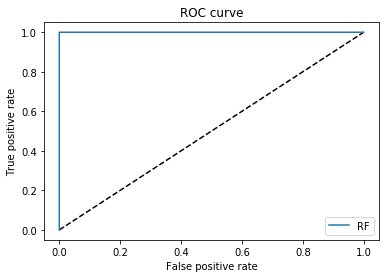

In [62]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Validation Metrics

              precision    recall  f1-score   support

           0       0.67      0.98      0.80      4766
           1       0.42      0.03      0.05      2359

    accuracy                           0.67      7125
   macro avg       0.55      0.50      0.42      7125
weighted avg       0.59      0.67      0.55      7125

Confusion Matrix
[[4683   83]
 [2298   61]]

Accuracy
0.6658245614035088


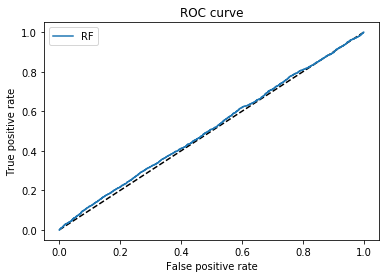

In [63]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [64]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc('2016-08-01 10:31:44.455000')
end = primary_forecast.index.get_loc('2017-12-29 21:03:37.018000') + 1

subset_prim = primary_forecast[start:end]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

KeyError: '2016-08-01 10:31:44.455000'

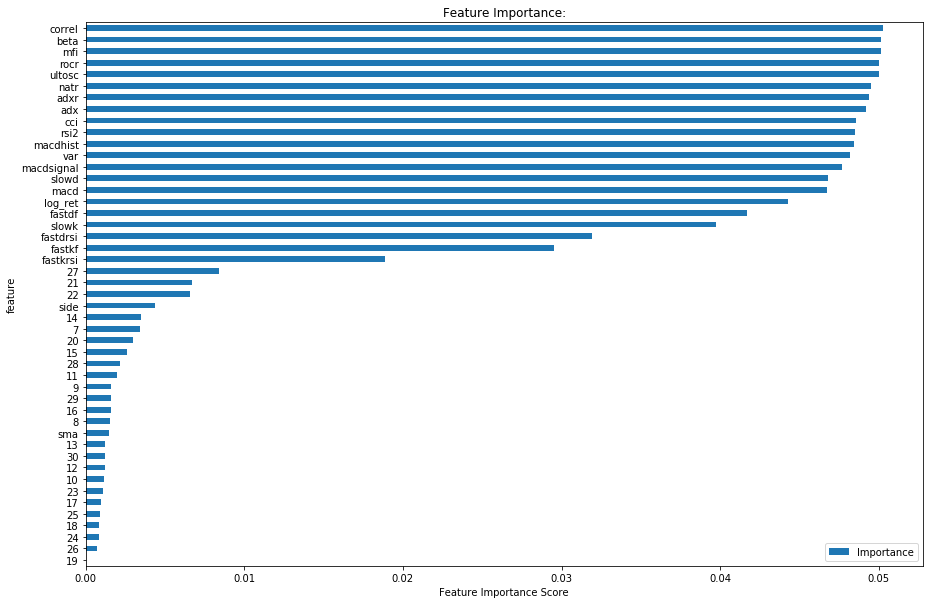

In [65]:
# Feature Importance
title = 'Feature Importance:'
figsize = (15, 10)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title=title, figsize=figsize)
plt.xlabel('Feature Importance Score')
plt.show()

# Performance Tear Sheets (In-sample)

In [ ]:
import pyfolio as pf

In [ ]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats

In [ ]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [ ]:


test_dates = X_validate.index

base_rets = labels.loc[test_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)

# Save the statistics in a dataframe
perf_stats_all = perf_func(primary_model_rets)
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

# pf.create_returns_tear_sheet(labels.loc[test_dates, 'ret'], benchmark_rets=None)
pf.show_perf_stats(primary_model_rets)



In [ ]:
#save the data as a new 

In [ ]:
.to_pickle